In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import islice
from typing import Iterator

import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm

# from kernels.triton.transformer import Transformer
from kernels.pytorch.transformer import Transformer

from kernels.pytorch.cross_entropy import cross_entropy

In [3]:
def collate_fn(batch: list[torch.Tensor]):
    lens = torch.tensor([len(b) for b in batch])
    max_l = max(lens)
    padded = torch.stack([torch.nn.functional.pad(b, (0, max_l - len(b) + 1), value=0) for b in batch])
    padded[torch.arange(len(lens)), lens] = 1
    return padded, lens + 1

In [4]:
class Dataset(torch.utils.data.IterableDataset):
    VOCAB = ["<PAD>", "<EOS>"] + [str(i) for i in range(10)] + ["+", "="]

    def __init__(self, max_int: int, seed: int):
        self.max_int = max_int
        self.seed = seed
        self.rng = np.random.default_rng(seed)
        self._idx_to_vocab = dict(enumerate(self.VOCAB))
        self._vocab_to_idx = {v: i for i, v in enumerate(self.VOCAB)}

    def to_idx(self, example: str) -> list[int]:
        return [self._vocab_to_idx[c] for c in example]
        
    def from_idx(self, example: list[int]):
        return "".join([self._idx_to_vocab[c] for c in example])

    def __iter__(self):
        while True:
            a = self.rng.integers(low=0, high=self.max_int)
            b = self.rng.integers(low=0, high=self.max_int)
            c = a + b
            yield torch.tensor(self.to_idx(f"{a}+{b}={c}"))

In [5]:
num_embeddings = len(Dataset.VOCAB)
depth = 4
d_model = 256
d_ff = int(64*((d_model*4*(2/3))//64))

n_head = d_model // 64

print(f"{num_embeddings=}, {d_model=}, {d_ff=}, {n_head=}")

num_embeddings=14, d_model=256, d_ff=640, n_head=4


In [6]:
ds = Dataset(100, seed=10)
dl = torch.utils.data.DataLoader(dataset=ds, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [7]:
model = Transformer(num_embeddings, depth, d_model, n_head, d_ff, device="cuda")

In [8]:
opt = torch.optim.AdamW(params=model.parameters(), lr=3e-4)

In [9]:
N = 10_000

In [10]:
losses = []

with tqdm.tqdm(total=N) as pbar:
    for i, (x, lens) in enumerate(islice(dl, N)):
        model.zero_grad(set_to_none=True)
        
        x = x.to("cuda")
        lens = lens.to("cuda")

        out = model(x[:, :-1].to("cuda"))
        
        loss = cross_entropy(out.flatten(end_dim=1), x[:, 1:].flatten())
        mask = (torch.arange(x.shape[1], device=x.device)[None, :] < lens[:, None])[:, :-1].flatten().float().to(x.device)
        loss = (loss * mask).sum() / mask.sum()
        
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        pbar.set_postfix_str(f"loss={losses[-1]:5.3f}")
        pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:20<00:00, 124.71it/s, loss=0.869]


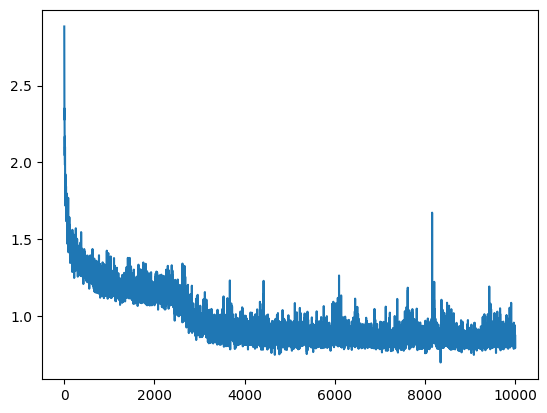

In [11]:
plt.plot(losses)